# Explore Annotations Extraction and Formatting

The notebook "extracting_formatting_annotations.ipynb" is meant to explore how we can extract the annotations from the data/metadata.pkl file, and use them to:
- Train a recognition model to read text from the detected text boxes.
- Format the annotations and the detected text boxes into a same format for evaluation.

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sys
import matplotlib.pyplot as plt
import pickle
import json

sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing.utils import rotate_image, compute_skew_angle_robust, extract_receipt_cluster_central, segment_image_gmm, segment_image_kmeans, resize_image, compute_nearest_32_multiple, compute_average_image_size, lighten_binarize_grayscale_image, crop_words_from_receipts

In [17]:
# Extract the annotations from the pkl file

with open('../data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

print(metadata.keys())  # Display the keys in the metadata dictionary

Index(['file_name', 'split_origin', 'words', 'bboxes', 'full_text'], dtype='object')


In [18]:
# Example: Display annotations for a specific image
example_image = 'test_receipt_00002.png'

file_names = metadata['file_name']
split_origins = metadata['split_origin']
words_list = metadata['words']
bboxes_list = metadata['bboxes']
full_texts = metadata['full_text']

index = file_names.values.tolist().index(example_image)
print(f"Annotations for {example_image}:")
print(f"  Split Origin: {split_origins[index]}")
print(f"  Full Text: {full_texts[index]}")
print(f"  Words: {words_list[index]}")
print(f"  Bounding Boxes: {bboxes_list[index]}")
    

Annotations for test_receipt_00002.png:
  Split Origin: test
  Full Text: 1 JASMINE MT ( L ) 24,000 COCONUT JELLY ( L ) 4,000 SUB TOTAL 28,000 TOTAL SAI S 28,000 TOTAL ITEMS 1 CASH 100,000 CHANGE 72,000
  Words: ['1', 'JASMINE', 'MT', '( L', ')', '24,000', 'COCONUT', 'JELLY', '( L', ')', '4,000', 'SUB', 'TOTAL', '28,000', 'TOTAL', 'SAI', 'S', '28,000', 'TOTAL', 'ITEMS', '1', 'CASH', '100,000', 'CHANGE', '72,000']
  Bounding Boxes: [{'x2': 178, 'y3': 672, 'x3': 178, 'y4': 672, 'x1': 168, 'y1': 652, 'x4': 168, 'y2': 652}, {'x2': 298, 'y3': 674, 'x3': 298, 'y4': 674, 'x1': 216, 'y1': 648, 'x4': 216, 'y2': 648}, {'x2': 334, 'y3': 674, 'x3': 334, 'y4': 674, 'x1': 306, 'y1': 648, 'x4': 306, 'y2': 648}, {'x2': 392, 'y3': 672, 'x3': 392, 'y4': 672, 'x1': 356, 'y1': 648, 'x4': 356, 'y2': 648}, {'x2': 414, 'y3': 672, 'x3': 414, 'y4': 672, 'x1': 402, 'y1': 652, 'x4': 402, 'y2': 652}, {'x2': 746, 'y3': 678, 'x3': 746, 'y4': 678, 'x1': 672, 'y1': 652, 'x4': 672, 'y2': 652}, {'x2': 298, 'y3': 710, '

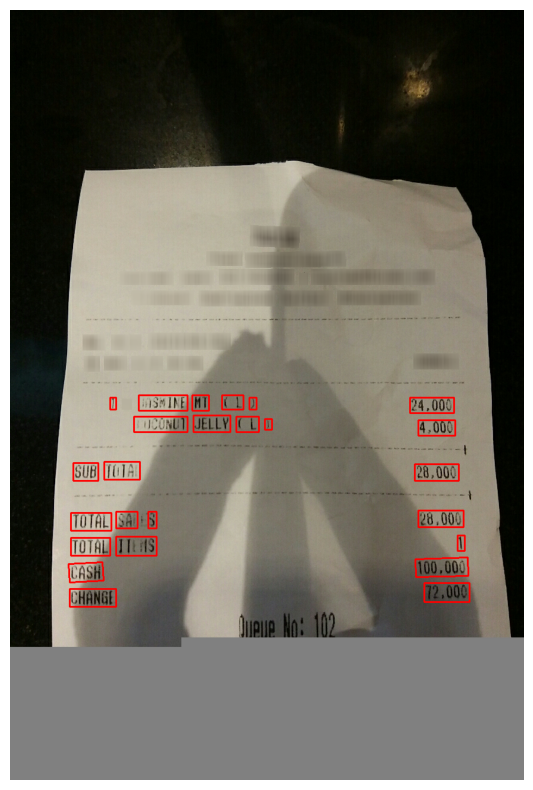

In [19]:
# display the bounding boxes for a given image

image_path = f"../data/images/{example_image}"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = bboxes_list[index]
for bbox in bboxes:
    # bbox is a dict with keys 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'
    pts = [(bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), (bbox['x3'], bbox['y3']), (bbox['x4'], bbox['y4'])]
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

---

In [24]:
considered_image = "dev_receipt_00002.png"

In [25]:
# Read the json preprocessed_bboxes.json file
with open('../data/preprocessed_bboxes.json', 'r') as f:
    preprocessed_bboxes = json.load(f)
    
with open('../data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
    
print(f"Preprocessed bounding boxes for {considered_image}:")
print(preprocessed_bboxes[considered_image])

# get the bboxes from the original metadata
file_names = metadata['file_name']
bboxes_list = metadata['bboxes']

index = file_names.values.tolist().index(considered_image)
original_bboxes = bboxes_list[index]

print(f"Original bounding boxes for {considered_image}:")
print(original_bboxes)

Preprocessed bounding boxes for dev_receipt_00002.png:
[{'x1': 288, 'y1': 668, 'x2': 444, 'y2': 666, 'x3': 442, 'y3': 714, 'x4': 288, 'y4': 713}, {'x1': 626, 'y1': 671, 'x2': 734, 'y2': 668, 'x3': 738, 'y3': 713, 'x4': 624, 'y4': 719}, {'x1': 372, 'y1': 628, 'x2': 449, 'y2': 630, 'x3': 445, 'y3': 671, 'x4': 369, 'y4': 669}, {'x1': 643, 'y1': 621, 'x2': 736, 'y2': 621, 'x3': 738, 'y3': 670, 'x4': 642, 'y4': 673}, {'x1': 336, 'y1': 709, 'x2': 446, 'y2': 712, 'x3': 444, 'y3': 763, 'x4': 334, 'y4': 760}, {'x1': 624, 'y1': 712, 'x2': 738, 'y2': 713, 'x3': 741, 'y3': 761, 'x4': 624, 'y4': 760}, {'x1': 353, 'y1': 756, 'x2': 446, 'y2': 755, 'x3': 446, 'y3': 803, 'x4': 351, 'y4': 803}, {'x1': 612, 'y1': 756, 'x2': 741, 'y2': 757, 'x3': 741, 'y3': 802, 'x4': 610, 'y4': 808}, {'x1': 316, 'y1': 847, 'x2': 447, 'y2': 846, 'x3': 445, 'y3': 895, 'x4': 312, 'y4': 896}, {'x1': 627, 'y1': 850, 'x2': 743, 'y2': 850, 'x3': 743, 'y3': 895, 'x4': 623, 'y4': 900}, {'x1': 74, 'y1': 505, 'x2': 94, 'y2': 507, '

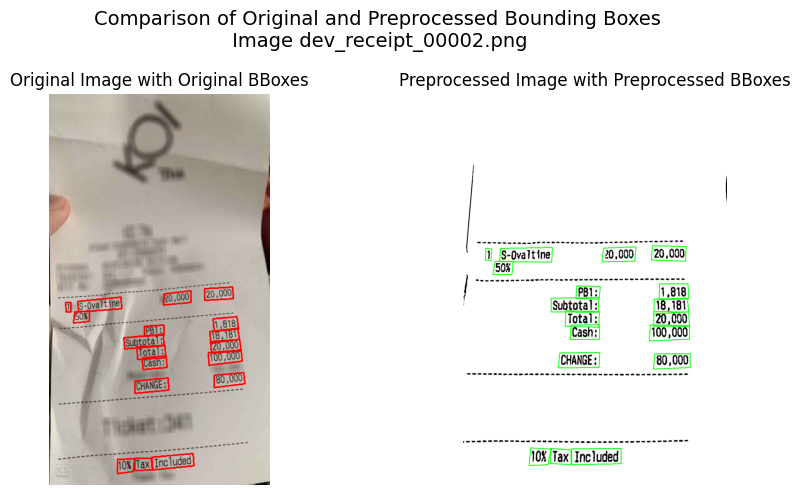

In [26]:
# display the preprocessed bounding boxes for a given image
image_path = f"../data/preprocessed_images/{considered_image}"
preprocessed_image = cv2.imread(image_path)
preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB)

original_image_path = f"../data/images/{considered_image}"
original_image = cv2.imread(original_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# make a copy of the image to draw original bounding boxes on
image_with_original_bboxes = original_image.copy()
for bbox in original_bboxes:
    pts = [(bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), (bbox['x3'], bbox['y3']), (bbox['x4'], bbox['y4'])]
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image_with_original_bboxes, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

# make a copy of the image to draw bounding boxes on
image_with_bboxes = preprocessed_image.copy()
bboxes = preprocessed_bboxes[considered_image]
for bbox in bboxes:
    pts = [(bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), (bbox['x3'], bbox['y3']), (bbox['x4'], bbox['y4'])]
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image_with_bboxes, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    
# Display the original image with bounding boxes, and the preprocessed image with bounding boxes side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image with Original BBoxes")
plt.imshow(image_with_original_bboxes)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Preprocessed Image with Preprocessed BBoxes")
plt.imshow(image_with_bboxes)
plt.axis('off')
plt.suptitle(f"Comparison of Original and Preprocessed Bounding Boxes\n Image {considered_image}", fontsize=14)
plt.tight_layout()
plt.savefig(f'../reports/figures/bboxes_comparison_{considered_image}.png')
plt.show()

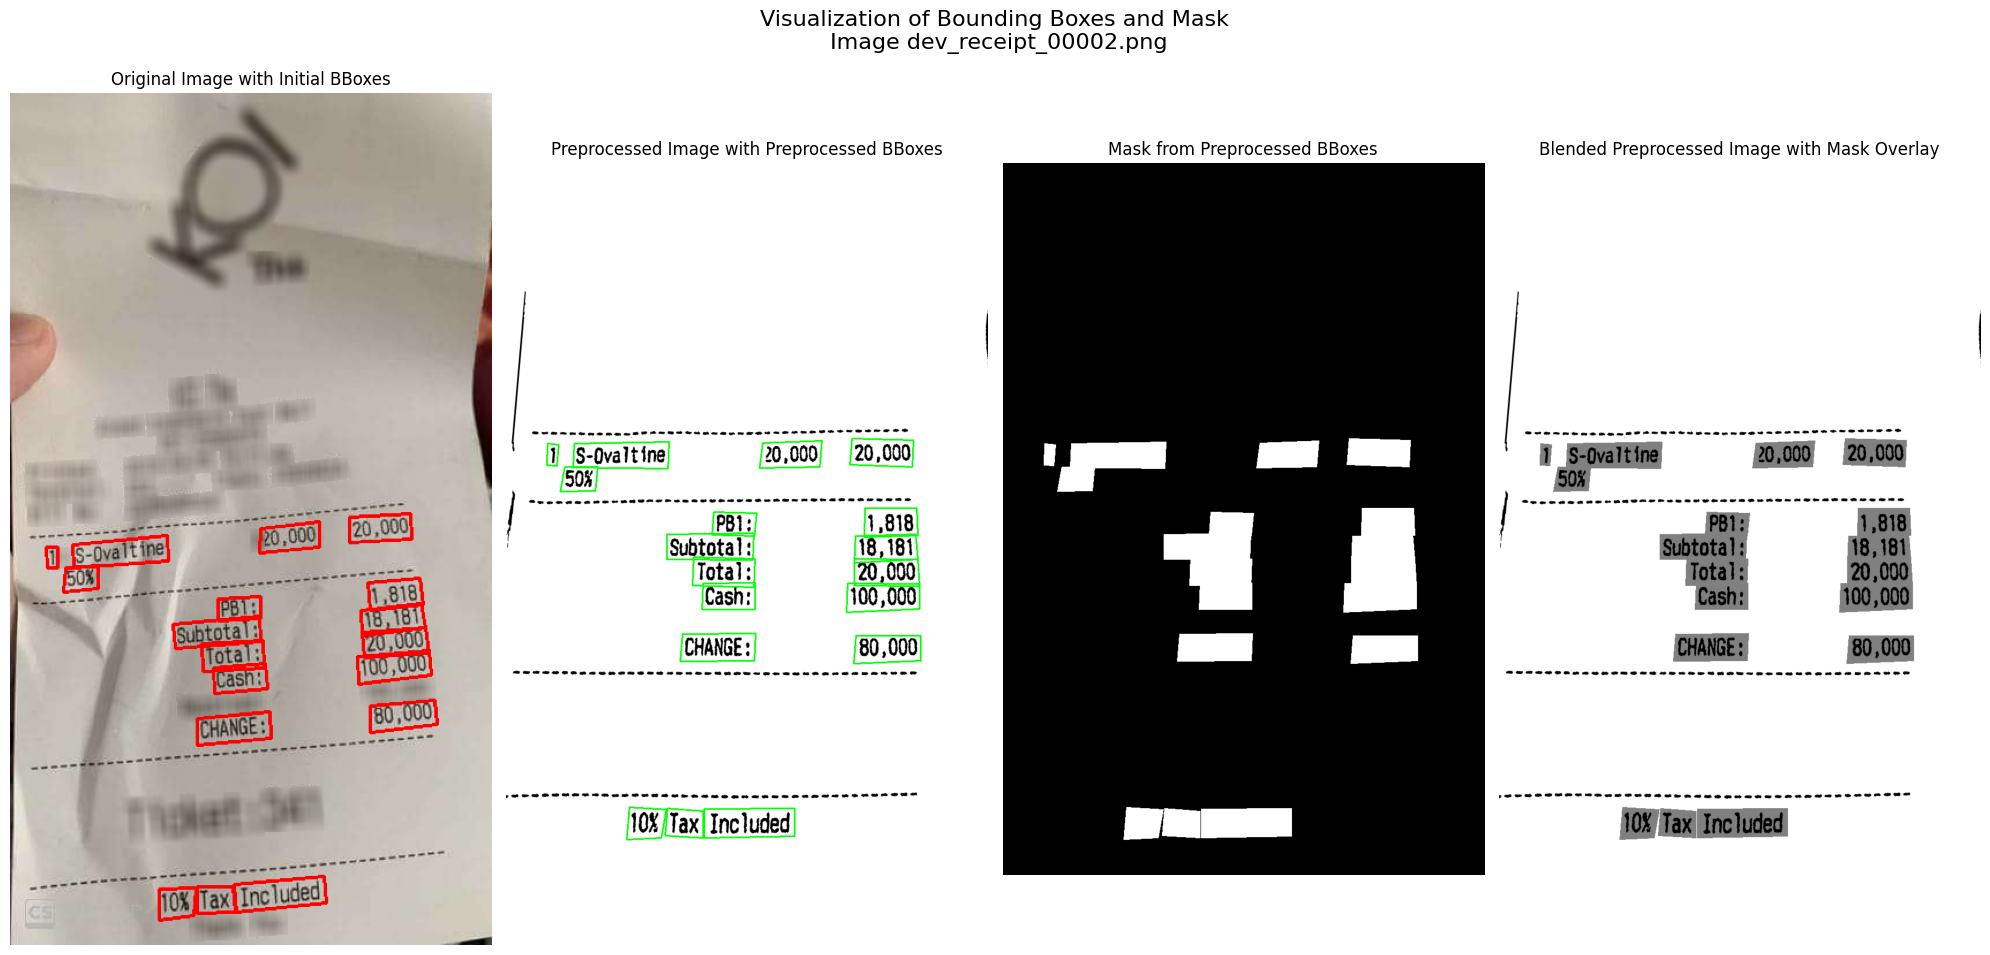

In [27]:
# Try to create a mask from the preprocessed bounding boxes and create a visualization 
# (copy of the preprocessed image with the mask overlaid)

mask = np.zeros(preprocessed_image.shape[:2], dtype=np.uint8)
bboxes = preprocessed_bboxes[considered_image]
for bbox in bboxes:
    pts = [(bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), (bbox['x3'], bbox['y3']), (bbox['x4'], bbox['y4'])]
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(mask, [pts], color=255)
overlay = preprocessed_image.copy()
# Black overlay where mask is present
overlay[mask == 255] = (0, 0, 0)
# Blend the images
alpha = 0.5
blended = cv2.addWeighted(preprocessed_image, 1 - alpha, overlay, alpha, 0)


# Display the four images side-by-side: original with bboxes, preprocessed with bboxes, mask, blended
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title("Original Image with Initial BBoxes")
plt.imshow(image_with_original_bboxes)
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title("Preprocessed Image with Preprocessed BBoxes")
plt.imshow(image_with_bboxes)
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title("Mask from Preprocessed BBoxes")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title("Blended Preprocessed Image with Mask Overlay")
plt.imshow(blended)
plt.axis('off')
plt.suptitle(f"Visualization of Bounding Boxes and Mask\n Image {considered_image}", fontsize=16)
plt.tight_layout()
plt.savefig(f'../reports/figures/bboxes_mask_blended_{considered_image.replace(".png", "")}.png')
plt.show()


Theoretically, we could now train a detection model to detect text boxes in the receipts. That way, we would be able to read any receipt, and predict the text boxes locations.

To do that first part, we would use as the input the preprocessed images, and as the target, either the images with the text boxes drawn on them, or the bounding box coordinates directly. Given our limited dataset size, the best target between those two options would probably be the bounding box coordinates directly. Indeed, should we want to use the images with the text boxes drawn on them as target, we would need to perform segmentation, which would require a model such as U-Net, which has too many parameters for our limited dataset size. Training a VGG-like model to predict bounding box coordinates directly would be more feasible.

Then, we could use the annotations to train a recognition model to read the text inside the detected boxes.
To do that second part, we will train the model on the preprocessed bounding boxes (rather than the full image), so that the model only has to focus on recognizing the text, rather than also detecting where it is.

We can now try to crop the bounding boxes from the preprocessed images, and see how they look like.
We give the example for the considered image.

In [2]:
considered_image = "dev_receipt_00000.png"

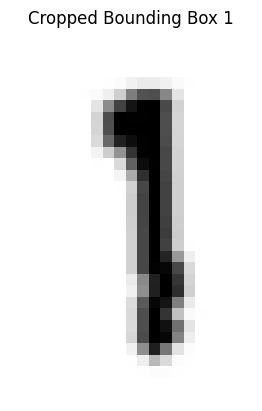

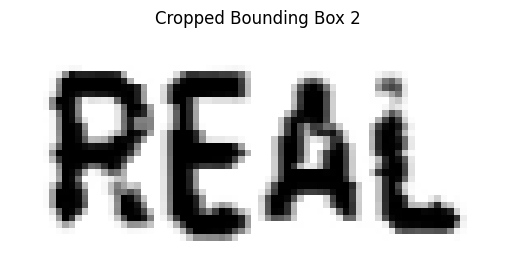

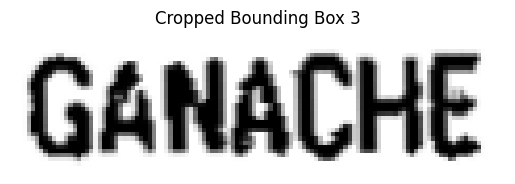

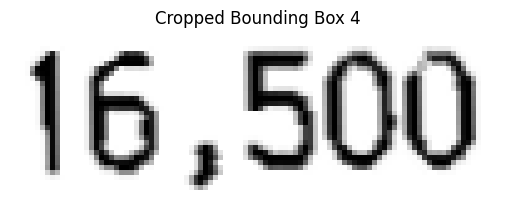

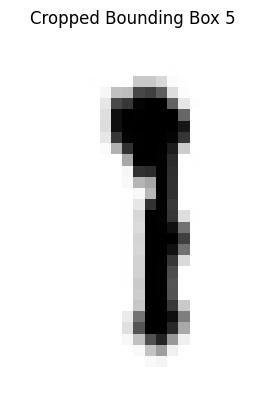

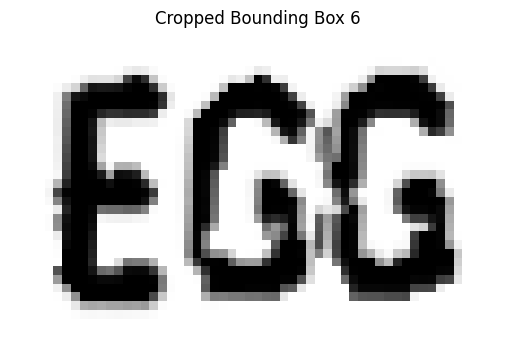

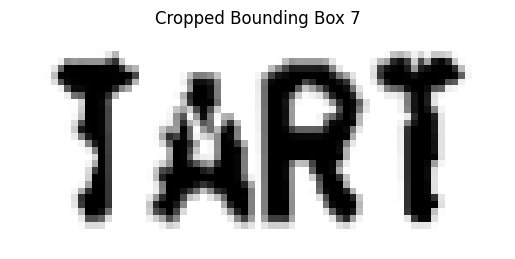

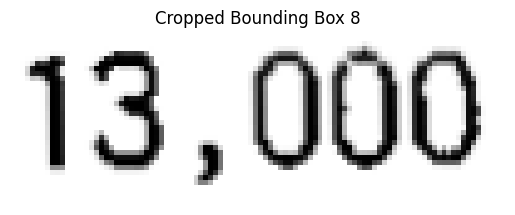

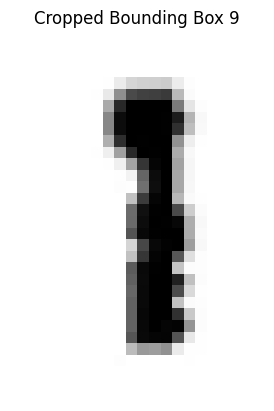

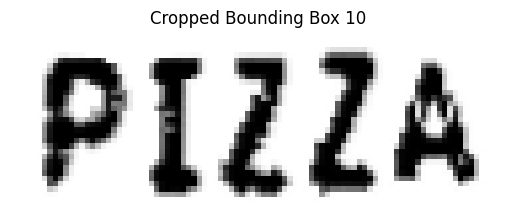

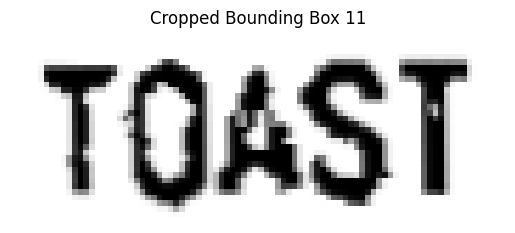

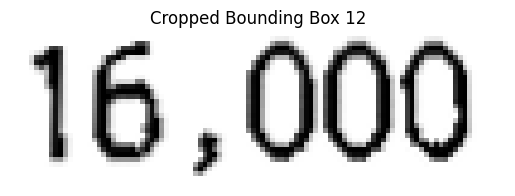

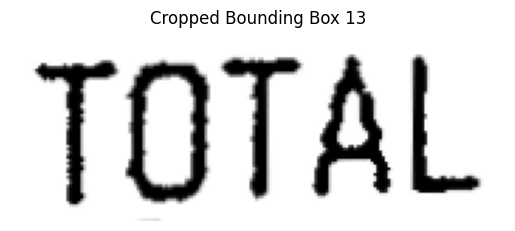

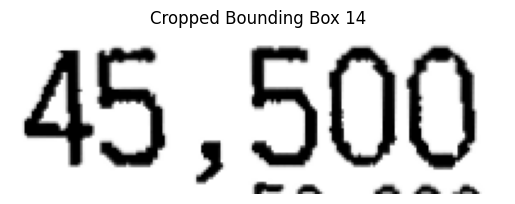

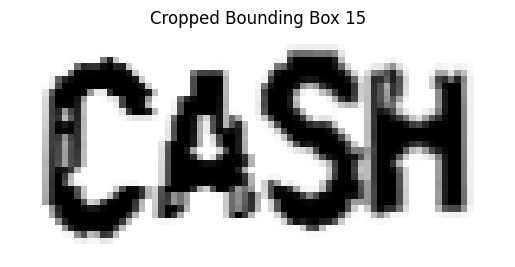

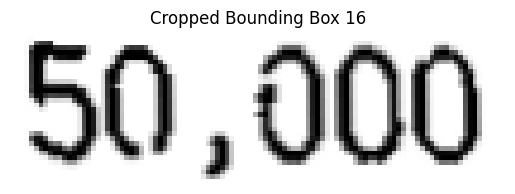

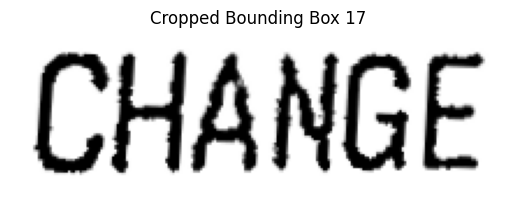

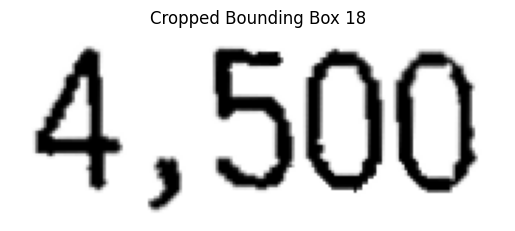

In [33]:
# Extracting and displaying cropped bounding box images from the preprocessed image
image_path = f"../data/preprocessed_images/{considered_image}"
preprocessed_image = cv2.imread(image_path)
preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB)
bboxes = preprocessed_bboxes[considered_image]
cropped_images = []
for i, bbox in enumerate(bboxes):
    pts = np.array([(bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), (bbox['x3'], bbox['y3']), (bbox['x4'], bbox['y4'])], dtype='float32')
    # Compute width and height of the bounding box
    width = int(max(np.linalg.norm(pts[0] - pts[1]), np.linalg.norm(pts[2] - pts[3])))
    height = int(max(np.linalg.norm(pts[0] - pts[3]), np.linalg.norm(pts[1] - pts[2])))
    dst_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(pts, dst_pts)
    warped = cv2.warpPerspective(preprocessed_image, M, (width, height))
    cropped_images.append(warped)
    # Display each cropped image
    plt.figure()
    plt.title(f"Cropped Bounding Box {i+1}")
    plt.imshow(warped)
    plt.axis('off')
    plt.show()

In [4]:
# Test the crop_words_from_receipts function on the considered image


cropped_word_images = crop_words_from_receipts(
    image_filename="dev_receipt_00000.png",
    preprocessed_images_dir="../data/preprocessed_images",
    preprocessed_bboxes_jsonfile="../data/preprocessed_bboxes.json",
    size=(128, 128),
    output_cropped_words_dir="../data/cropped_word_images",
    map_filename_to_word_files_json="../data/filename_to_word_files.json"
)

